## Large Data Limits paper
This is just a rough first version, not entirely true to what it should be. 

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE

In [3]:
def run_rescaled_tsne(data, kappa=30, alpha=0.1):
    """
    Run t-SNE with a rescaled perplexity and exaggeration factor.

    Parameters:
      - data: ndarray of shape (n_samples, n_features)
      - kappa: base constant (effective number of neighbors)
      - alpha: exponent to allow perplexity to grow as n^alpha
      
    Returns:
      - embedding: 2D embedding from t-SNE.
    """
    n, d = data.shape
    # Note: b needs to be larger than 1/d and smaller than 1 
    b = 0.12
    h_n = n ** (-b)
    # Perplexity should be chosen to scale slowly with n.
    scaled_perplexity = kappa * (n ** alpha)
    # Early exaggeration factor: rescale the attractive term by 1/h_n^2.
    exaggeration = 1 / (h_n ** 2)
    
    print(f"n = {n}, d = {d}, b={b}")
    print(f"Computed h_n = {h_n:.4f}")
    print(f"Using perplexity = {scaled_perplexity:.2f} (base κ = {kappa}, exponent α = {alpha})")
    print(f"Using early exaggeration = {exaggeration:.2f}")

    tsne = TSNE(
        perplexity=scaled_perplexity,
        early_exaggeration_iter=250,
        exaggeration=exaggeration,
        initialization="pca",
        n_jobs=-1,
        random_state=42,
    )
    embedding = tsne.fit(data)
    return embedding


In [4]:
def create_synthetic_data(n_points=10000, n_features=50, n_clusters=5, cluster_std=1.0):
    """
    Generate synthetic data as a mixture of Gaussians.
    """
    np.random.seed(42)
    data = []
    labels = []
    centers = np.random.randn(n_clusters, n_features) * 0.7
    points_per_cluster = n_points // n_clusters
    for i in range(n_clusters):
        points = centers[i] + cluster_std * np.random.randn(points_per_cluster, n_features)
        data.append(points)
        labels.append(np.full(points.shape[0], i))
    data = np.vstack(data)
    labels = np.concatenate(labels)

    indices = np.random.permutation(n_points)
    return data[indices], labels[indices]


In [5]:
def run_standard_tsne(data, perplexity=30, exaggeration=12):
    """
    Run standard t-SNE with fixed perplexity and exaggeration.
    """
    tsne = TSNE(
        perplexity=perplexity,
        early_exaggeration_iter=250,
        exaggeration=exaggeration,
        initialization="pca",
        n_jobs=4,
        random_state=42,
    )
    return tsne.fit(data)

## Experiments: Varying Samples Sizes - Comparison rescaled and standard t-SNE

### first attempt

In [6]:
data_all, labels_all = create_synthetic_data(n_points=1000000, n_features=50, n_clusters=5)
def comp_rescaled_tsne_on_sizes(data_sizes): 
    for n_fixed in data_sizes: 

        sampled_indices = np.random.choice(len(data_all), size=n_fixed, replace=False)

        # Select the random subset of data and labels
        data_subset = data_all[sampled_indices]
        labels_subset = labels_all[sampled_indices]

        # Standard t-SNE (with constant perplexity and exaggeration)
        emb_standard = run_standard_tsne(data_subset, perplexity=30, exaggeration=12)

        # Rescaled t-SNE (per our new model)
        emb_rescaled = run_rescaled_tsne(data_subset, kappa=30, alpha=0.05)

        # cmap = plt.get_cmap("Set1")

        # Plot side-by-side
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(emb_standard[:, 0], emb_standard[:, 1], c=labels_subset[:n_fixed], cmap="Set1", s=5)
        plt.title(f"Standard t-SNE, {n_fixed} points")
    
        plt.subplot(1, 2, 2)
        plt.scatter(emb_rescaled[:, 0], emb_rescaled[:, 1], c=labels_subset[:n_fixed], cmap="Set1", s=5)
        plt.title(f"Rescaled t-SNE, {n_fixed} points")
    
        plt.tight_layout()
        plt.show()

Perplexity value 37 is too high. Using perplexity 33.00 instead


n = 100, d = 50, b=0.12
Computed h_n = 0.5754
Using perplexity = 37.77 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 3.02


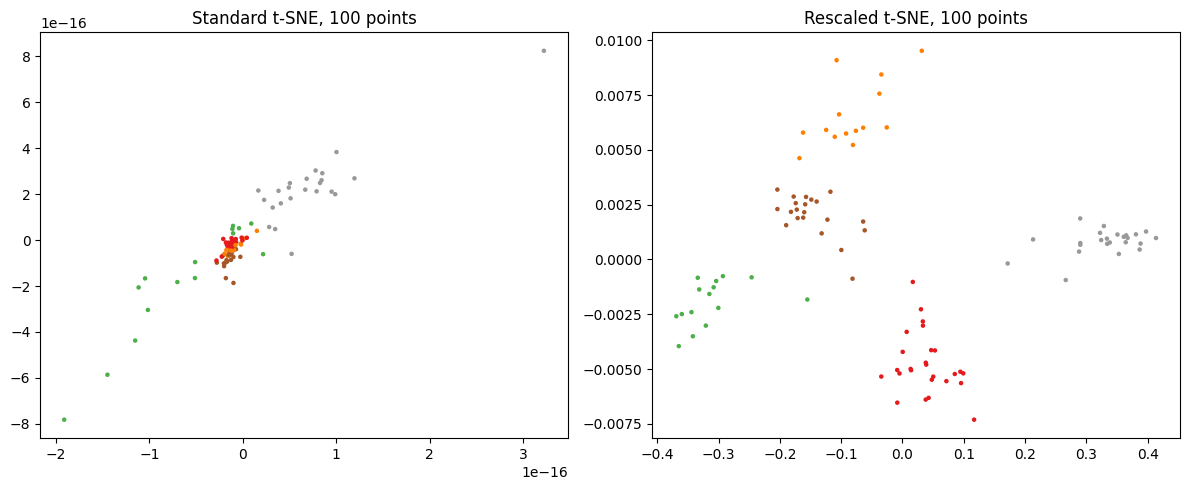

n = 500, d = 50, b=0.12
Computed h_n = 0.4744
Using perplexity = 40.93 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 4.44


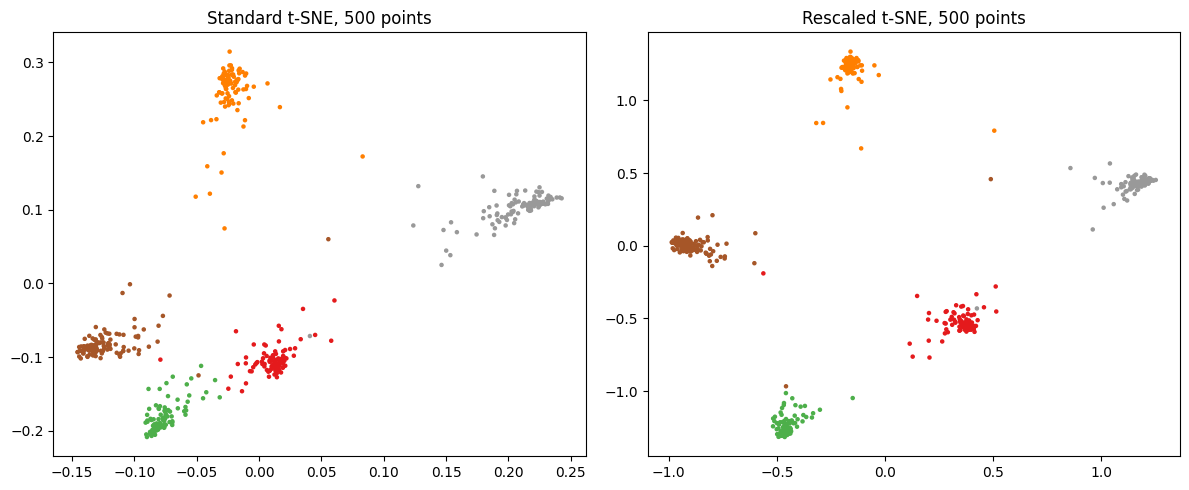

In [7]:
comp_rescaled_tsne_on_sizes([100, 500])

Perplexity value 37 is too high. Using perplexity 33.00 instead


n = 100, d = 50, b=0.12
Computed h_n = 0.5754
Using perplexity = 37.77 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 3.02


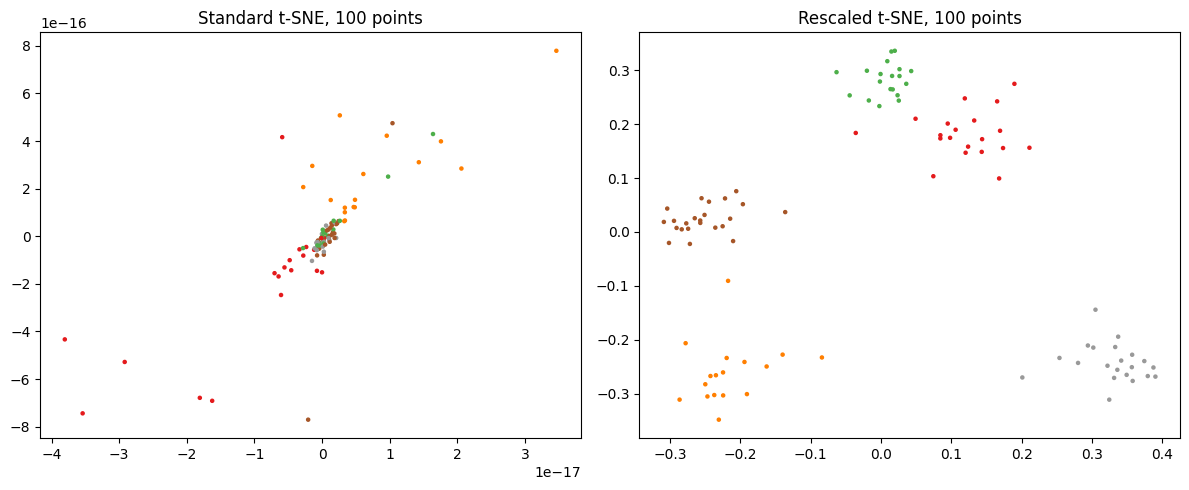

n = 500, d = 50, b=0.12
Computed h_n = 0.4744
Using perplexity = 40.93 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 4.44


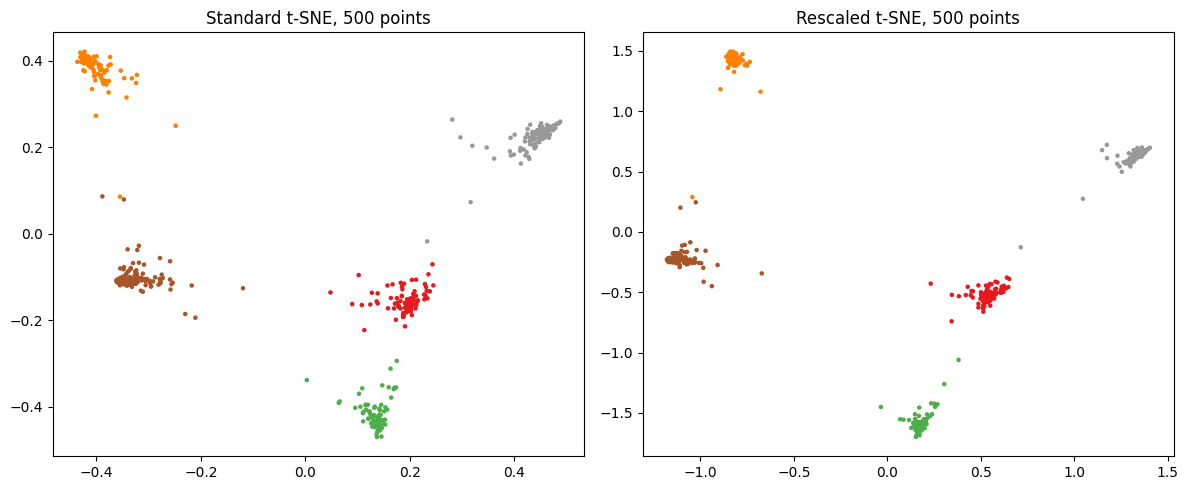

n = 1000, d = 50, b=0.12
Computed h_n = 0.4365
Using perplexity = 42.38 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 5.25


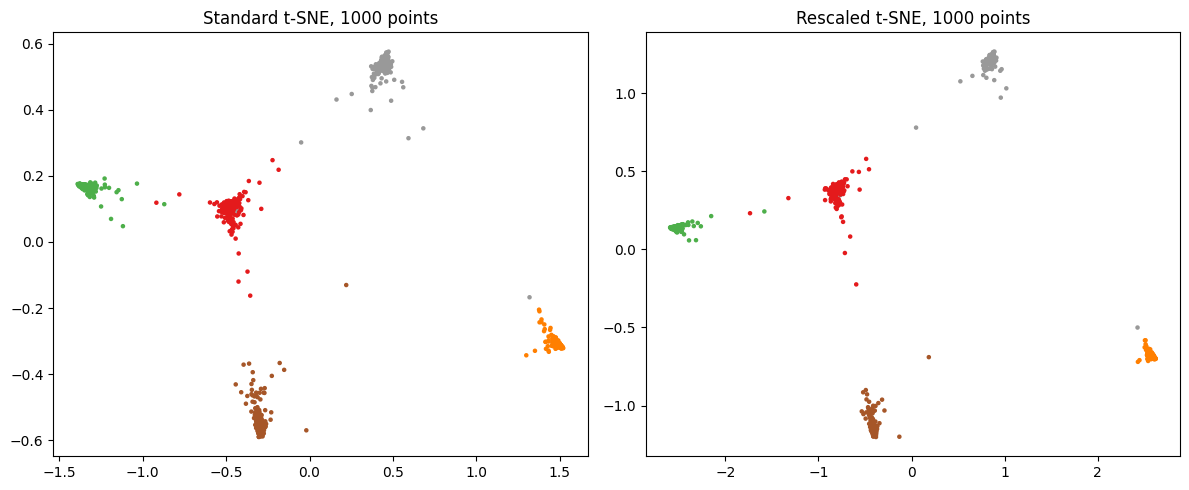

n = 10000, d = 50, b=0.12
Computed h_n = 0.3311
Using perplexity = 47.55 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 9.12


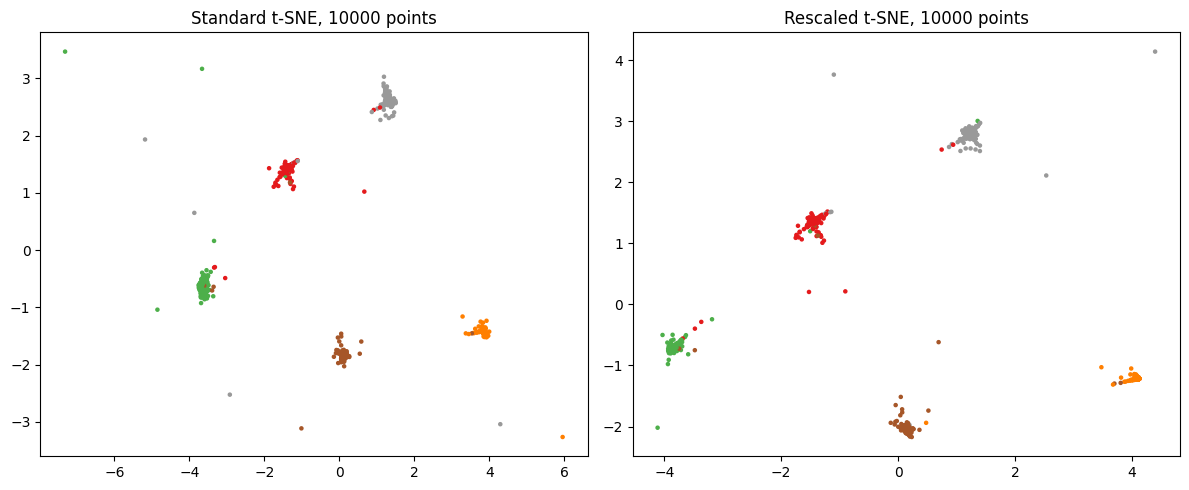

n = 100000, d = 50, b=0.12
Computed h_n = 0.2512
Using perplexity = 53.35 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 15.85


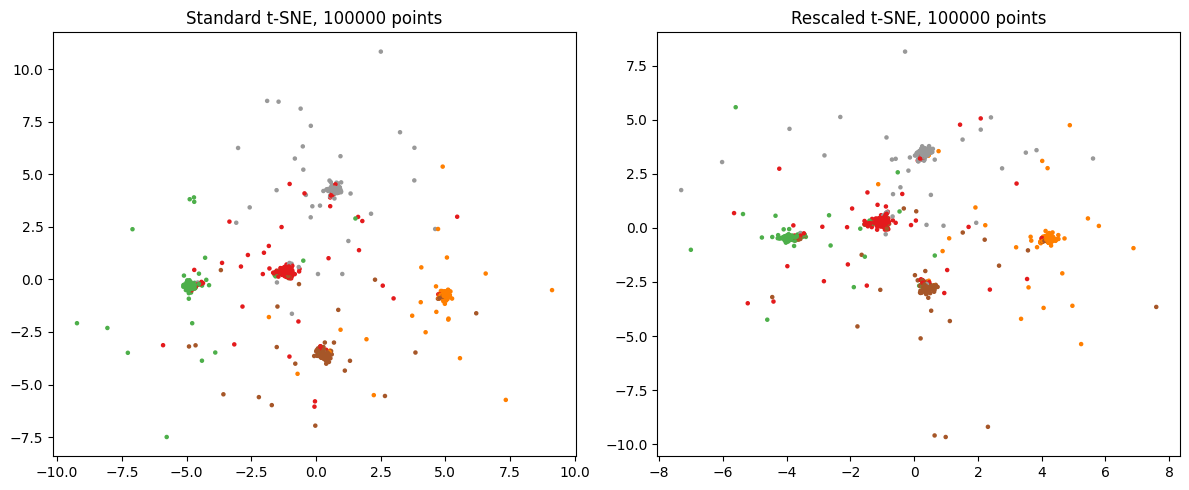

n = 1000000, d = 50, b=0.12
Computed h_n = 0.1905
Using perplexity = 59.86 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 27.54


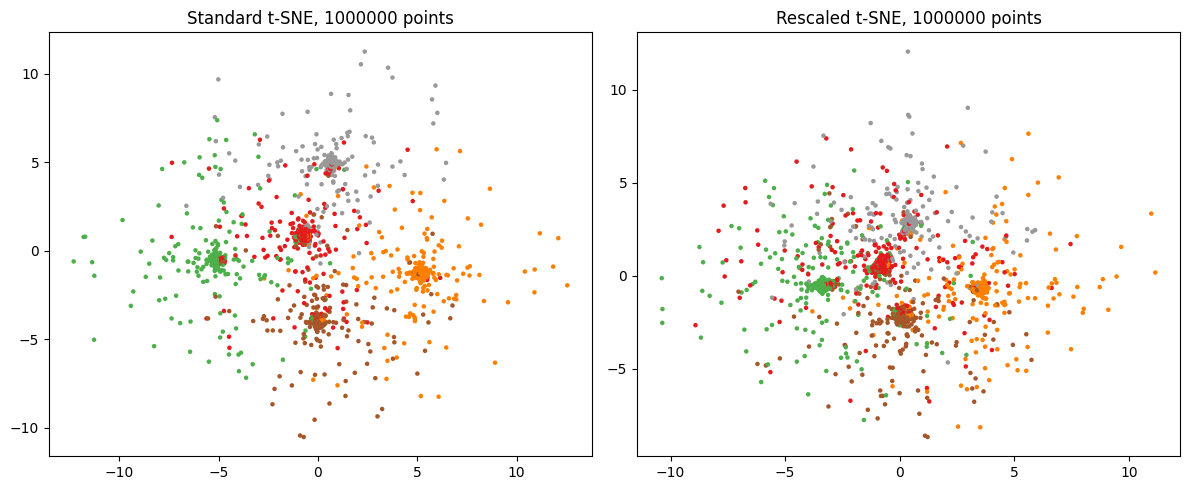

In [8]:
comp_rescaled_tsne_on_sizes([100, 500, 1000, 10000, 100000, 1000000])

### second attempt

In [5]:
def run_rescaled_tsne_improved(data, kappa=30, alpha=0.1, b=0.15):
    """
    Run t-SNE with a rescaled perplexity and exaggeration factor.

    Parameters:
      - data: ndarray of shape (n_samples, n_features)
      - kappa: base constant (effective number of neighbors)
      - alpha: exponent to allow perplexity to grow as n^alpha
      
    Returns:
      - embedding: 2D embedding from t-SNE.
    """
    n, d = data.shape
    # Note: b needs to be larger than 1/d and smaller than 1 
    h_n = n ** (-b)
    # Perplexity should be chosen to scale slowly with n.
    scaled_perplexity = kappa * (n ** alpha)
    # Early exaggeration factor: rescale the attractive term by 1/h_n^2.
    exaggeration = 1 / (h_n ** 2)
    
    print(f"n = {n}, d = {d}, b={b}")
    print(f"Computed h_n = {h_n:.4f}")
    print(f"Using perplexity = {scaled_perplexity:.2f} (base κ = {kappa}, exponent α = {alpha})")
    print(f"Using early exaggeration = {exaggeration:.2f}")

    # keep on EE for the entirety of the optimization  
    tsne = TSNE(
        perplexity=scaled_perplexity,
        early_exaggeration=exaggeration,
        exaggeration=exaggeration, 
        n_jobs=-1,
        random_state=42,
        verbose=True
    )
    embedding = tsne.fit(data)
    return embedding

In [6]:
def run_standard_tsne_improved(data):
    """
    Run standard t-SNE with fixed perplexity and exaggeration.
    """
    tsne = TSNE(n_jobs=-1, random_state=42, verbose=True
    )
    return tsne.fit(data)

In [11]:
def sample_gaussian_mixture(n_samples: int, dim: int, n_components: int = 5, spread: float = 5.0):
    """
    Generates samples from a Gaussian Mixture Model with equidistant Gaussian components in high dimensions.

    Parameters:
    - n_samples (int): Total number of samples to generate.
    - dim (int): Dimensionality of the data.
    - n_components (int): Number of Gaussian components (default: 5).
    - spread (float): Controls how far apart the Gaussian centers are (default: 5.0).

    Returns:
    - X (numpy.ndarray): Sampled data of shape (n_samples, dim).
    - labels (numpy.ndarray): Cluster labels for each sample.
    """
    np.random.seed(42)

    # Generate random Gaussian centers in high-dimensional space
    means = np.random.randn(n_components, dim) * spread  # Spread them apart

    # Covariance matrices (identity matrices for simplicity)
    covariances = [np.eye(dim) for _ in range(n_components)]

    # Equal mixing probabilities (each Gaussian has 1/n_components probability)
    component_choices = np.random.choice(n_components, size=n_samples, p=np.ones(n_components) / n_components)

    # Sample from the selected Gaussians
    X = np.array([np.random.multivariate_normal(means[comp], covariances[comp]) for comp in component_choices])

    return X, component_choices  # Return data and the labels indicating which Gaussian each point came from


In [15]:
def compare_improved(data_sizes, b=0.15, dim=50, n_components=5):
    """
    Generates and compares standard vs. rescaled t-SNE embeddings for different sample sizes.

    Parameters:
    - data_sizes (list): List of sample sizes to generate and compare.
    - dim (int): Dimensionality of the generated data (default: 50).
    - n_components (int): Number of Gaussian components in the mixture (default: 5).
    """
    num_rows = len(data_sizes)  # Number of rows in the plot
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))  # Adjust figure size dynamically
    fig.suptitle("Comparison of Standard vs. Rescaled t-SNE for Different Sample Sizes", fontsize=12, y=1.02)

    for i, n_fixed in enumerate(data_sizes):
        # Sample new data instead of selecting a subset
        data_sample, labels = sample_gaussian_mixture(n_samples=n_fixed, dim=dim, n_components=n_components)

        # Compute embeddings
        emb_standard = run_standard_tsne_improved(data_sample)
        emb_rescaled = run_rescaled_tsne_improved(data_sample, kappa=30, alpha=0.05, b=b)

        # Plot standard t-SNE
        axes[i, 0].scatter(emb_standard[:, 0], emb_standard[:, 1], c=labels, cmap="Set1", s=5)
        axes[i, 0].set_title(f"Standard t-SNE ({n_fixed} points)")

        # Plot rescaled t-SNE
        axes[i, 1].scatter(emb_rescaled[:, 0], emb_rescaled[:, 1], c=labels, cmap="Set1", s=5)
        axes[i, 1].set_title(f"Rescaled t-SNE ({n_fixed} points)")

    plt.tight_layout()
    plt.show()


--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=-1, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=8.33 for 250 iterations...
Iteration   50, KL divergence 1.0155, 50 iterations in 0.2698 sec
Iteration  100, KL divergence 1.0673, 50 iterations in 0.1318 sec
Iteration  150, KL divergence 0.9953, 50 iterations in 0.0974 sec
Iteration  200, KL divergence 1.0388, 50 iterations in 0.1136 sec
Iteration  250, KL divergence 1.0292, 50 iterations in 0.1446 sec
   --> Time elapsed: 0.76 seconds
===> Running optimization with exaggeration=1.00, lr=100.00

Perplexity value 37 is too high. Using perplexity 33.00 instead


Iteration  450, KL divergence 0.0068, 50 iterations in 0.2587 sec
Iteration  500, KL divergence 0.0068, 50 iterations in 0.1100 sec
   --> Time elapsed: 2.04 seconds
n = 100, d = 50, b=0.15
Computed h_n = 0.5012
Using perplexity = 37.77 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 3.98
--------------------------------------------------------------------------------
TSNE(early_exaggeration=3.981071705534973, exaggeration=3.981071705534973,
     n_jobs=-1, perplexity=37.76776235382502, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 99 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.04 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=3.98, lr=25.12 for 250 iterations...
Iteration   50, KL divergence 0.3647, 5

KeyboardInterrupt: 

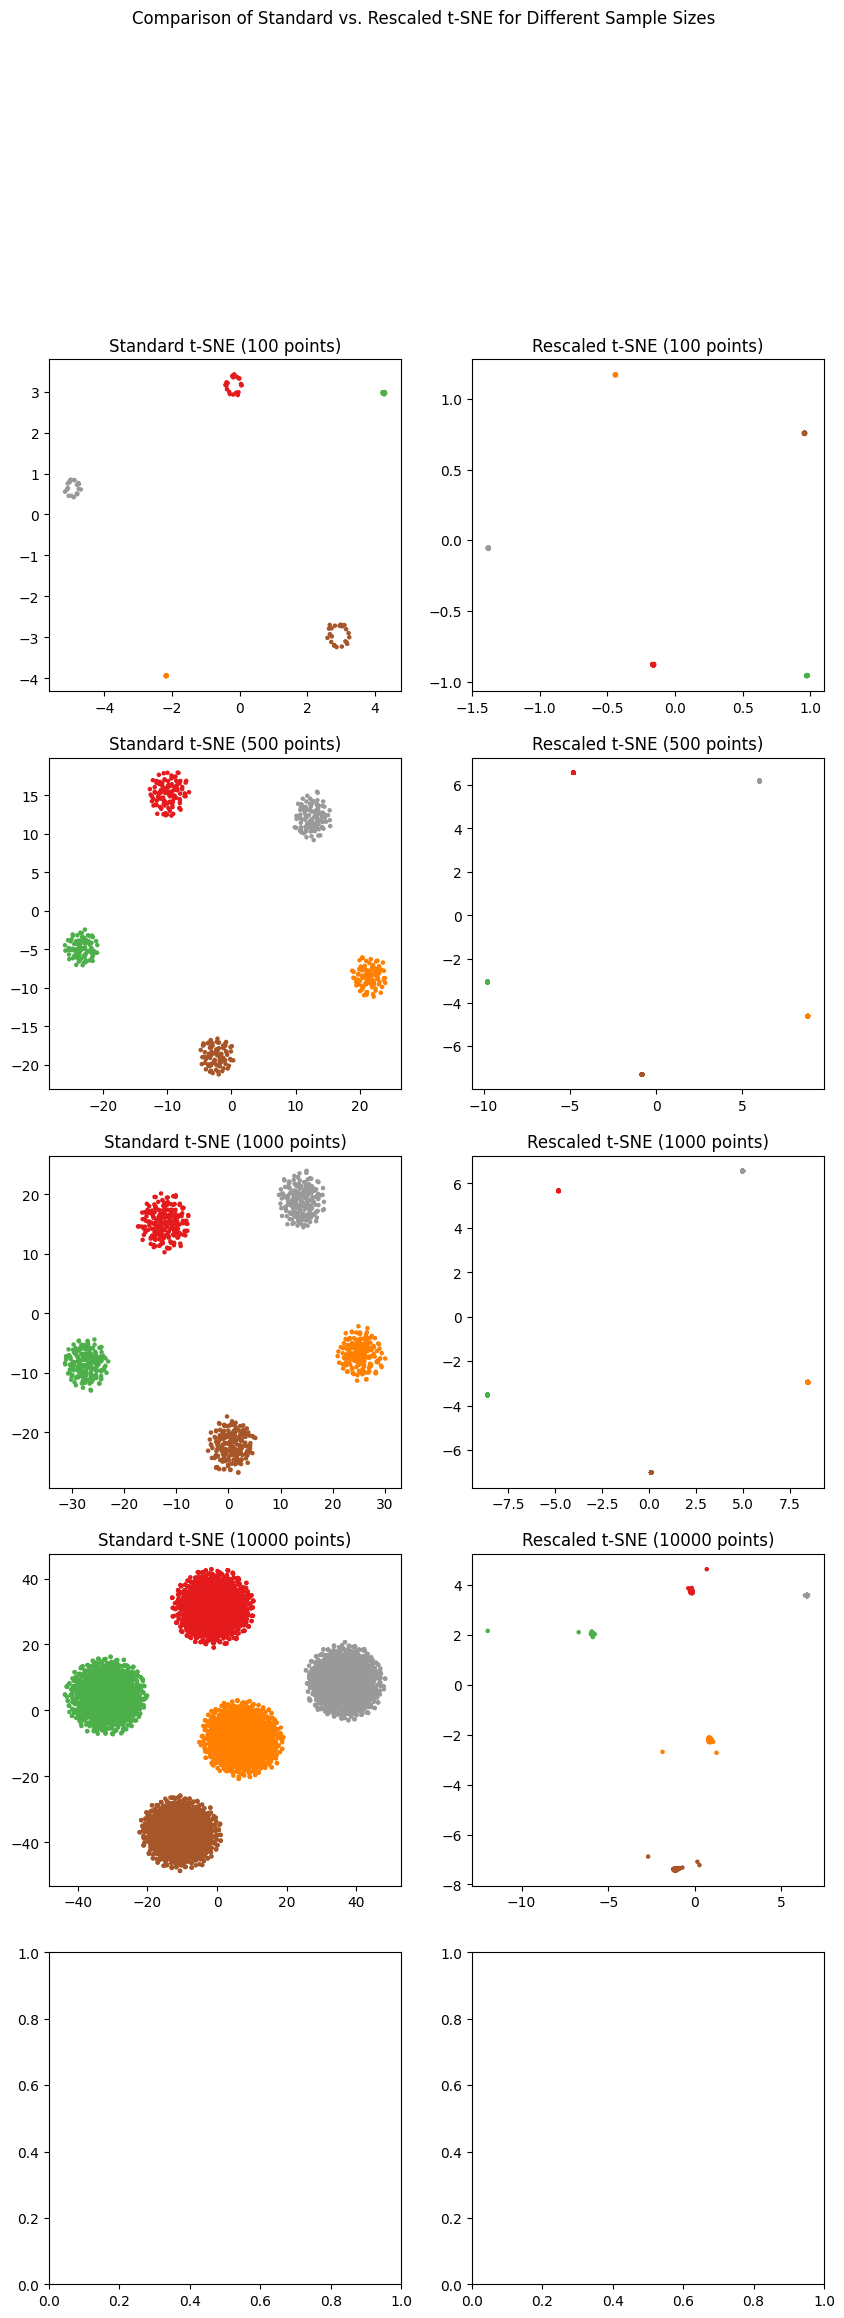

In [18]:
compare_improved([100, 500, 1000, 10000, 100000], b=0.15)
compare_improved([100, 500, 1000, 10000, 100000], b=0.05)